# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

Multi-level ensemble

In [6]:
ls = [7, 8, 9]

In [7]:
args_list = []
init_list = []

for l in ls:
    doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=2**l, nx=2**(l+1))
    doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

    args_list.append(doubleJetCase_args)
    init_list.append(doubleJetCase_init)

In [8]:
from utils.DoubleJetParametersReplication import * 

In [9]:
truth = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init)
truth.updateDt()
truth.setKLModelError(**sim_model_error_basis_args)
truth.model_time_step = sim_model_error_timestep

In [10]:
ML_Nes = [100, 50, 10]

In [11]:
from utils.DoubleJetEnsembleInit import *
ML_ensemble = initMLensemble(ML_Nes, args_list, init_list,
                             sim_model_error_basis_args=sim_model_error_basis_args, 
                             sim_model_error_time_step=sim_model_error_timestep)

from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

0
1
2


Ranks

In [12]:
# Rank locations 
rank_xs = np.array([0.5, 128.5, 256.5, 384.5])*2601.5625
rank_ys = np.array([0.5,  42.5, 84.5, 126.5, 168.5, 210.5])*2601.5625

rank_obs_xs, rank_obs_ys = np.array(np.meshgrid(rank_xs, rank_ys)).T.reshape(-1, 2).T

# Convert to indices
rank_idxs = MLOceanEnsemble.loc2idxs(rank_obs_xs[0], rank_obs_ys[0])

rank_idxs[0] = np.array(rank_idxs[0])
for l_idx in range(1, len(ls)):
    rank_idxs[l_idx][0] = np.array(rank_idxs[l_idx][0])
    rank_idxs[l_idx][1] = np.array(rank_idxs[l_idx][1])

for r_idx in range(1, len(rank_obs_xs)):
    tmp_rank_idxs = MLOceanEnsemble.loc2idxs(rank_obs_xs[r_idx], rank_obs_ys[r_idx])
    
    rank_idxs[0] = np.c_[rank_idxs[0], tmp_rank_idxs[0]]
    for l_idx in range(1, len(ls)):
        rank_idxs[l_idx][0] = np.c_[rank_idxs[l_idx][0], tmp_rank_idxs[l_idx][0]]
        rank_idxs[l_idx][1] = np.c_[rank_idxs[l_idx][1], tmp_rank_idxs[l_idx][1]]

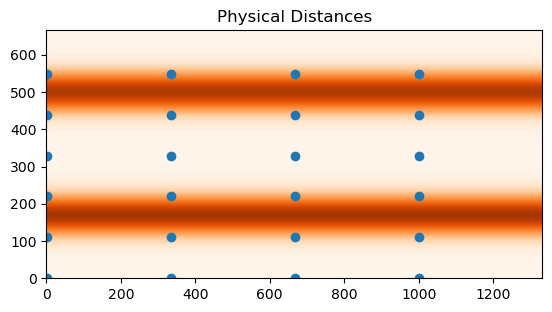

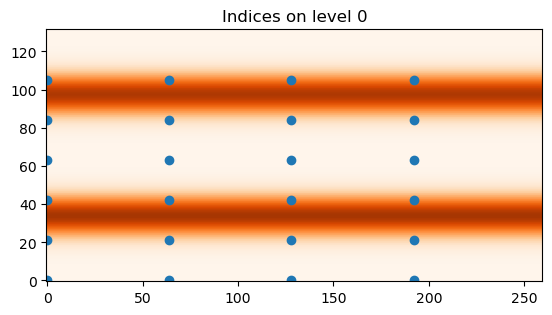

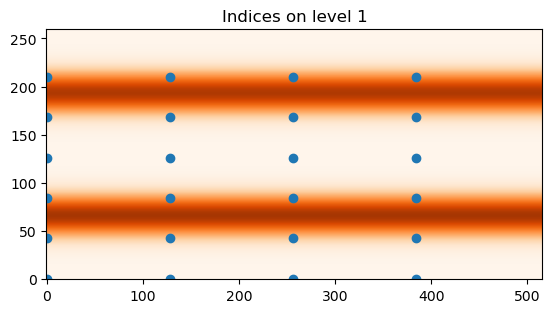

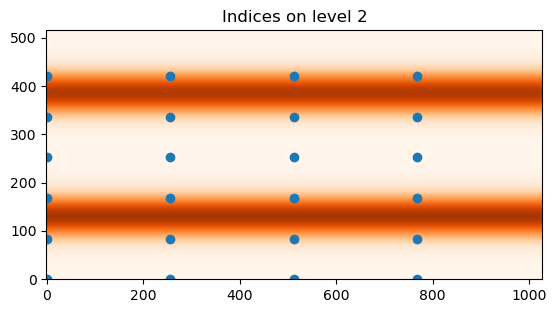

In [25]:
H = doubleJetCase_args["H"][0][0]

u = doubleJetCase_init["hu0"]/H
v = doubleJetCase_init["hv0"]/H

extent = [0, doubleJetCase_args["dx"]*doubleJetCase_args["nx"]/1000, 0, doubleJetCase_args["dy"]*doubleJetCase_args["ny"]/1000]

plt.figure()
plt.title("Physical Distances")
plt.imshow(np.sqrt(u**2+v**2), cmap="Oranges", vmin=0.0, vmax=3.5, extent=extent)
plt.scatter(rank_obs_xs/1000, rank_obs_ys/1000)


plt.figure()
plt.title("Indices on level 0")
u = init_list[0]["hu0"]/H
v = init_list[0]["hv0"]/H
plt.imshow(np.sqrt(u**2+v**2), cmap="Oranges", vmin=0.0, vmax=3.5)
plt.scatter(rank_idxs[0][1], rank_idxs[0][0])


for l_idx in range(1, len(ls)):
    plt.figure()
    plt.title("Indices on level "+str(l_idx))
    u = init_list[l_idx]["hu0"]/H
    v = init_list[l_idx]["hv0"]/H
    plt.imshow(np.sqrt(u**2+v**2), cmap="Oranges", vmin=0.0, vmax=3.5)
    plt.scatter(rank_idxs[l_idx][0][1], rank_idxs[l_idx][0][0])

In [26]:
ML_state = MLOceanEnsemble.download()
np.save("DoubleJet-MLDA4Ranks_MLvalues_0.npy", np.array(ML_state[0][:,rank_idxs[0][0],rank_idxs[0][1]]))
for l_idx in range(1,len(ls)):
    np.save("DoubleJet-MLDA4Ranks_MLvalues_"+str(l_idx)+"_0.npy", np.array(ML_state[l_idx][0][:,rank_idxs[l_idx][0][0],rank_idxs[l_idx][0][1]]))
    np.save("DoubleJet-MLDA4Ranks_MLvalues_"+str(l_idx)+"_1.npy", np.array(ML_state[l_idx][1][:,rank_idxs[l_idx][1][0],rank_idxs[l_idx][1][1]]))

In [28]:
ML_values = []
ML_values.append( np.load("DoubleJet-MLDA4Ranks_MLvalues_0.npy") )
for l_idx in range(1, len(ls)):
    ML_values.append( [np.load("DoubleJet-MLDA4Ranks_MLvalues_"+str(l_idx)+"_0.npy"), np.load("DoubleJet-MLDA4Ranks_MLvalues_"+str(l_idx)+"_1.npy")] )

In [51]:
ML_values[1][0][0,0]#.shape

array([2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885,
       2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885,
       2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885,
       2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885,
       2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885,
       2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885,
       2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885,
       2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885, 2.2177885,
       2.2177885, 2.2177885], dtype=float32)

In [54]:
MLOceanEnsemble.rank(truth, [[1,1]])

[array([0., 0., 0.])]

In [68]:
r_idx = 0

In [69]:
np.array(truth.download(interior_domain_only=True))[:,rank_idxs[-1][0][0][r_idx],rank_idxs[-1][0][1][r_idx]]

array([2.2388763, 0.060536 , 0.       ], dtype=float32)

In [70]:
ML_state[0][:,rank_idxs[0][0][r_idx],rank_idxs[0][1][r_idx],:]

array([[2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.17

In [72]:
ML_values[0][:, r_idx, :]

array([[2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.176742  , 2.176742  ,
        2.176742  , 2.176742  , 2.176742  , 2.17